`MNIST` 手写体识别是图像识别中最经典的问题，希望能够识别出人类手写的数字。数据是65000张灰度图和对对应的数字。用之前的深度神经网络来尝试解决这个问题。

In [1]:
import tensorflow as tf
import numpy as np

#Tensorflow 已经把 mnist 数据集集成在 examples 里面了
#在这里 import 数据输入的部分
import tensorflow.examples.tutorials.mnist.input_data as input_data

tf.set_random_seed(2017)

首先导入 `mnist` 数据集

**注意** 下载数据需要一定时间，如果下面这行代码下载出现问题，可以从网上下载 MNIST 数据集，然后一起放到 `MNIST_data` 这个文件夹中，文件夹的结构应该是下面这样：
```
    MNIST_data
        train-images-idx3-ubyte.gz
        train-labels-idx1-ubyte.gz
        t10k-images-idx3-ubyte.gz
        t10k-labels-idx1-ubyte.gz
```

In [2]:
mnist = input_data.read_data_sets('MNIST_data', one_hot = True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


注意到 `read_data_sets` 的一个参数是 `one_hot`([独热编码](https://baike.baidu.com/item/独热编码/9717350?fr=aladdin))

它是识别任务中非常重要的一个概念，将一个数值 `n` 映射到一个向量，这个向量的第 `n` 个元素是 `1` ，其他元素都是 `0`。

这个书局街分成了两个部分：训练和测试。分开来是为了观察模型在完全没有见过的数据上的表现，从而体现泛化能力

In [3]:
train_set = mnist.train
test_set = mnist.test

具体看看数据

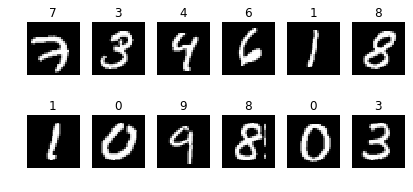

In [4]:
import matplotlib.pyplot as plt

%matplotlib inline

fig, axes = plt.subplots(ncols = 6, nrows = 2)
plt.tight_layout(w_pad = -2.0, h_pad = -8.0)

# 调用next_batch方法来一次性获取12个样本
# 这里有一个‘shuffle’参数，表达是否打乱样本间的顺序
images, labels = train_set.next_batch(12, shuffle = False)

for ind, (image, label) in enumerate(zip(images, labels)):
    # image 是一个 784 维的向量，是图片进行拉伸产生的，这里把它 reshape 回去
    image = image.reshape((28, 28))
    
    # label 是一个 10 维的向量，哪个下标处的值为 1 说明是数字几（独热编码）
    label = label.argmax()
    
    row = ind // 6
    col = ind % 6
    axes[row][col].imshow(image, cmap = 'gray') #灰度图
    axes[row][col].axis('off')
    axes[row][col].set_title('%d' % label)

接下来定义深度网络结构

In [5]:
def hidden_layer(layer_input, output_depth, scope = 'hidden_layer', reuse = None):
    input_depth = layer_input.get_shape()[-1]
    with tf.variable_scope(scope, reuse = reuse):
        # 注意这里的初始方法是truncated_normal
        w = tf.get_variable(initializer = tf.truncated_normal_initializer(stddev = 0.1), 
                            shape = (input_depth, output_depth), name = 'weights')
        
        # 注意这里用 0.1 对偏置进行初始化
        b = tf.get_variable(initializer = tf.constant_initializer(0.1), shape = (output_depth), name = 'bias')
        net = tf.matmul(layer_input, w) + b
        
        return net
    
    
def DNN(x, output_depths, scope = 'DNN', reuse = None):
    net = x
    
    for i, output_depth in enumerate(output_depths):
        net = hidden_layer(net, output_depth, scope = 'layer%d' % i, reuse = reuse)
        #注意这里的激活函数
        net = tf.nn.relu(net)
        
    # 数字分为 0, 1, ..., 9 所以这是10分类问题
    # 对应于 one_hot 的标签，所以这里输出一个 10维 的向量
    net = hidden_layer(net, 10, scope = 'classification', reuse = reuse)
    
    return net

In [6]:
# 定义占位符

input_ph = tf.placeholder(shape = (None, 784), dtype = tf.float32)
label_ph = tf.placeholder(shape = (None, 10), dtype = tf.int64)

构造一个5层的神经网络，每层的节点分别为：784，400，200，100，10

In [7]:
dnn = DNN(input_ph, [400, 200, 100])

In [8]:
# 这是一个分类问题，因此采用交叉熵来计算损失函数
loss = tf.losses.softmax_cross_entropy(logits = dnn, onehot_labels = label_ph)

# 下面定义的是正确率，注意理解它为什么是这么定义的
acc = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(dnn, axis = -1), tf.argmax(label_ph, axis = -1)), dtype = tf.float32))

lr = 0.001
optimizer = tf.train.GradientDescentOptimizer(learning_rate = lr)
train_op = optimizer.minimize(loss)

In [9]:
sess = tf.InteractiveSession()

In [10]:
# 训练20000次

batch_size = 64

sess.run(tf.global_variables_initializer())

for e in range(20000):
    
    # 获取 batch_size 个训练样本
    images, labels = train_set.next_batch(batch_size)
    sess.run(train_op, feed_dict = {input_ph: images, label_ph: labels})
    
    if e % 1000 == 999:
        
        # 获取 batch_size 个测试样本
        test_imgs, test_labels = test_set.next_batch(batch_size)
        
        # 计算在当前样本上的训练以及测试样本的损失值和正确率
        loss_train, acc_train = sess.run([loss, acc], feed_dict = {input_ph: images, label_ph: labels})
        loss_test, acc_test = sess.run([loss, acc], feed_dict = {input_ph: test_imgs, label_ph: test_labels})
        
        print('STEP {}: train_loss: {:.6f} train_acc: {:.6f} test_loss: {:.6f}  test_acc: {:.6f}'.format(e + 1, loss_train, acc_train, loss_test, acc_test))
              
print('Train Done!')
print('-' * 30)

# 计算所有训练样本的损失值以及正确率
train_loss = []
train_acc = []

for _ in range(train_set.num_examples // 100):
    image, label = train_set.next_batch(100)
    loss_train, acc_train = sess.run([loss, acc], feed_dict = {input_ph: image, label_ph: label})
    train_loss.append(loss_train)
    train_acc.append(acc_train)
    
print('Train loss: {:.6f}'.format(np.array(train_loss).mean()))
print('Train accuracy: {:.6f}'.format(np.array(train_acc).mean()))

# 计算所有测试样本的损失之以及正确率
test_loss = []
test_acc = []

for _ in range(test_set.num_examples // 100):
    image, label = test_set.next_batch(100)
    loss_test, acc_test = sess.run([loss, acc], feed_dict = {input_ph: image, label_ph: label})
    test_loss.append(loss_test)
    test_acc.append(acc_test)
    
print('Test loss: {:.6f}'.format(np.array(test_loss).mean()))
print('Test accuracy: {:.6f}'.format(np.array(test_acc).mean()))

STEP 1000: train_loss: 1.485448 train_acc: 0.609375 test_loss: 1.202393  test_acc: 0.765625
STEP 2000: train_loss: 0.856910 train_acc: 0.765625 test_loss: 0.718500  test_acc: 0.859375
STEP 3000: train_loss: 0.620737 train_acc: 0.812500 test_loss: 0.440792  test_acc: 0.921875
STEP 4000: train_loss: 0.590660 train_acc: 0.828125 test_loss: 0.467028  test_acc: 0.843750
STEP 5000: train_loss: 0.478044 train_acc: 0.906250 test_loss: 0.551444  test_acc: 0.890625
STEP 6000: train_loss: 0.265536 train_acc: 0.937500 test_loss: 0.489413  test_acc: 0.843750
STEP 7000: train_loss: 0.406452 train_acc: 0.921875 test_loss: 0.457152  test_acc: 0.875000
STEP 8000: train_loss: 0.418945 train_acc: 0.859375 test_loss: 0.286238  test_acc: 0.937500
STEP 9000: train_loss: 0.299432 train_acc: 0.875000 test_loss: 0.342349  test_acc: 0.890625
STEP 10000: train_loss: 0.442951 train_acc: 0.843750 test_loss: 0.312232  test_acc: 0.906250
STEP 11000: train_loss: 0.238033 train_acc: 0.953125 test_loss: 0.221827  test_

可以看到，最后在训练集和测试集合上都达到了大约0.9的正确率，是一个相当不错的成绩了

In [11]:
sess.close()

# Tensorboard & `tf.summary`

前面已经介绍过如何使用 `Tensorboard` 将构建的计算图显示出来，这里还有介绍它和 `tf.summary` 结合起来体现的更加强大的功能：可视化训练。

首先介绍一下 `tf.summary` ，它能够手机训练过程中的各种 `tensor` 的信息并把它保存起来以供 `Tensorboard` 读取并展示。按照下面的方法来使用它：

# 构造 `summary`

---         
* 如果想收集表示一个标量或者一个数的 `tensor` 的信息，比如上面的 `loss`    
```python
loss_sum = tf.summary.scalar('loss', loss)
```     
上面的语句就会告诉 `Tensorflow` ，在运行过程中，要让 `Tensorboard` 显示误差的变化了

---
* 如果想收集一个 `tensor` 的分布情况，这个 `tensor` 可以是任意形状，比如定义了一个 `(784, 400)` 的权重 `w`
```python
w_hist = tf.summary.histogram('w_hist', w)
```
---
* 如果想收集一个4维的1-通道（灰度图），3-通道（RGB），4-（RGBA）的 `tensor` 的变化，比如输出了一个 `(1, 8, 8, 1)` 的灰度图 `image`
```python
image_sum = tf.summary.image('image', image)
```
---
* 如果想收集一个3维(batch, frame, channel)，2维(batch, frame)的变化，比如输出了一个 `(10, 50, 3)` 的 `tensr` : `audio`
```python
audio_sum = tf.summary.audio('audio', audio)
```
---
在本篇介绍中，暂时先使用 `scalar` 和 `histogram` 的 `summary` ， `image` 和 `audio` 的 `summary` 将在之后再介绍

In [12]:
# 重置计算图
tf.reset_default_graph()

#重新定义占位符
input_ph = tf.placeholder(shape = (None, 784), dtype = tf.float32)
label_ph = tf.placeholder(shape = (None, 10), dtype = tf.int64)

现在，需要重新构建前向神经网络，为了简化代码，在构造一个隐藏层以及它的参数的函数内部构造 `tf.summary`

In [13]:
# 构造权重，用 `truncated_normal` 初始化
def weight_variable(shape):
    init = tf.truncated_normal(shape = shape, stddev = 0.1)
    return tf.Variable(init)

# 构造偏置，用 ‘0.1’ 初始化
def bias_variable(shape):
    init = tf.constant(0.1, shape = shape)
    return tf.Variable(init)

In [14]:
# 构造添加 ‘variable’ 的 ‘summary’ 的函数
def variable_summaries(var):
    with tf.name_scope('summaries'):
        
        #计算平均值
        mean = tf.reduce_mean(var)
        
        #将平均值添加到 ‘summary‘ 中，这是一个数值，所以用 'tf.summary.scalar'
        tf.summary.scalar('mean', mean)
        
        # 计算标准差
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
            
        # 将标准差添加到 ‘summary’ 中
        tf.summary.scalar('stddev', stddev)
        
        # 添加最大值，最小值 ‘summary’
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        
        # 添加这个变量分布情况的 ’summary‘， 希望观察它的分布，所以用’tf.summary.histogram‘
        tf.summary.histogram('histogram', var)

In [15]:
# 构造一个隐藏层
def hidden_layer(x, output_dim, scope = 'hidden_layer', act = tf.nn.relu, reuse = None):
    input_dim = x.get_shape().as_list()[-1]
    
    with tf.name_scope(scope):
        with tf.name_scope('weight'):
            # 构造 ‘weight；
            weight = weight_variable([input_dim, output_dim])
            # 添加 ‘weight’ 的 ‘summary’
            variable_summaries(weight)
            
        with tf.name_scope('bias'):
            # 构造 'bias'
            bias = bias_variable([output_dim])
            # 添加 ‘bias’ 的 ‘summary’
            variable_summaries(bias)
            
        with tf.name_scope('linear'):
            # 计算 ‘x * w + b’
            preact = tf.matmul(x,  weight) + bias
            # 添加激活层之前输出的分布情况‘summary’
            tf.summary.histogram('pre_activation', preact)
            
        # 经过激活层 ‘act’
        output = act(preact)
        # 添加激活后输出的分布情况到 ‘summary’
        tf.summary.histogram('output', output)
        return output
    
    
    
# 构造深度神经网络
def DNN(x, output_depths, scope = 'DNN_with_sums', reuse = None):
    with tf.name_scope(scope):
        net = x
        for i, output_depth in enumerate(output_depths):
            net = hidden_layer(net, output_depth, scope = 'hidden%d' % (i + 1), reuse = reuse)
            
        #最后一个分类层.
        #其中，有点想不明白参数 ‘act=tf.identity’ 的作用，
        #难道是让上面定义hidden_layer时定义好的 ‘act = tf.nn.relu’ 不执行吗，
        #因为下面 ‘tf.losses.softmax_cross_entropy’ 自带softmax激活函数，所以不让最后一层linear在输出之前进入激活函数，
        net = hidden_layer(net, 10, scope = 'classification', act = tf.identity, reuse = reuse)
        return net
    
dnn_with_sums = DNN(input_ph, [400, 200, 100])

In [16]:
# 重新定义 ‘loss’，‘acc’，‘train_op’
with tf.name_scope('cross_entropy'):
    loss = tf.losses.softmax_cross_entropy(logits = dnn_with_sums, onehot_labels = label_ph)
    tf.summary.scalar('cross_entropy', loss)
    
with tf.name_scope('accuracy'):
    acc = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(dnn_with_sums, axis = -1), tf.argmax(label_ph, axis = -1)), 
                                 dtype = tf.float32))
    tf.summary.scalar('accuracy', acc)
    
with tf.name_scope('train'):
    lr = 0.01
    optimizer = tf.train.GradientDescentOptimizer(learning_rate = lr)
    train_op = optimizer.minimize(loss)

# （可选）融合 `summary`
- - -
- 我们可以把前面定义的所有`summary`都融合成一个`summary`
```python
merged = tf.summary.merge_all()
```
- - -
- 也可以只是融合某些`summary`
```python
merged = tf.summary.merge([loss_sum, image_sum])
```

In [17]:
merged = tf.summary.merge_all()

In [18]:
sess = tf.InteractiveSession()

# 输出 `summary`
---
`summary`是需要导出到外部文件的
- 首先定义一个文件读写器
```python
summary_writer = tf.summary.FileWriter('summaries', sess.graph)
```
- - -
- 然后在训练的过程中, 在你希望的时候运行一次`merged`或者是你之前自己定义的某个通过`summary`定义的`op`
```python
summaries = sess.run(merged, feed_dict={...})
```
- - -
- 然后将这个`summaries`写入到`summari_writer`内
```python
summary_writer.add_summary(summaries, step)
```
注意`step`表示你当前训练的步数, 当然你也可以设定为其他你想要用的数值

- - -
- 最后关闭文件读写器
```python
summary_writer.close()
```

In [19]:
train_writer = tf.summary.FileWriter('test_summary/train', sess.graph)
test_writer = tf.summary.FileWriter('test_summary/test', sess.graph)

In [21]:
batch_size = 64

sess.run(tf.global_variables_initializer())

for e in range(20000):
    images, labels = train_set.next_batch(batch_size)
    sess.run(train_op, feed_dict = {input_ph: images, label_ph: labels})
    
    if e % 1000 == 999:
        test_imgs, test_labels = test_set.next_batch(batch_size)
        # 获取 ‘train’ 数据的 ‘summaries’ 以及 ’loss‘，’acc‘ 信息
        sum_train, loss_train, acc_train = sess.run([merged, loss, acc], feed_dict = {input_ph: images, label_ph: labels})
        
        # 将 ‘train' 数据的 ’summaries‘ 写入到 ’train_writer‘ 中
        train_writer.add_summary(sum_train, e)
        
        # 获取 ’test‘ 数据的 ’summaries‘ 以及 ’loss‘，‘acc’ 信息
        sum_test, loss_test, acc_test = sess.run([merged, loss, acc], feed_dict = {input_ph: test_imgs,  label_ph: test_labels})
        
        # 将 'test' 的 ’summaries‘ 写入到 ’test_writer' 中
        test_writer.add_summary(sum_test, e)
        
        print('STEP {}: train_loss: {:.6f} train_acc: {:.6f} test_loss: {:.6f} test_acc: {:.6f}'.format(e + 1, loss_train, acc_train, loss_test, acc_test))

# 关闭读写器
train_writer.close()
test_writer.close()

print('Train Done!')
print('-' * 30)

# 计算所有训练样本的损失率以及正确率
train_loss = []
train_acc = []

for _ in range(train_set.num_examples // 100):
    image, label = train_set.next_batch(100)
    loss_train, acc_train = sess.run([loss, acc], feed_dict = {input_ph: image, label_ph: label})
    train_loss.append(loss_train)
    train_acc.append(acc_train)
    
    
print('Train loss: {:.6f}'.format(np.array(train_loss).mean()))
print('Train accuracy: {:.6f}'.format(np.array(train_acc).mean()))

# 计算所有测试样本的损失之以及正确率
test_loss = []
test_acc = []

for _ in range(test_set.num_examples // 100):
    image, label = test_set.next_batch(100)
    loss_test, acc_test = sess.run([loss, acc], feed_dict = {input_ph: image, label_ph: label})
    test_loss.append(loss_test)
    test_acc.append(acc_test)
    
print('Test loss: {:.6f}'.format(np.array(test_loss).mean()))
print('Test accuracy: {:.6f}'.format(np.array(test_acc).mean()))

STEP 1000: train_loss: 0.430697 train_acc: 0.843750 test_loss: 0.355455 test_acc: 0.906250
STEP 2000: train_loss: 0.140123 train_acc: 0.968750 test_loss: 0.401140 test_acc: 0.875000
STEP 3000: train_loss: 0.167068 train_acc: 0.937500 test_loss: 0.258671 test_acc: 0.906250
STEP 4000: train_loss: 0.145217 train_acc: 0.953125 test_loss: 0.096235 test_acc: 0.968750
STEP 5000: train_loss: 0.147932 train_acc: 0.968750 test_loss: 0.080337 test_acc: 0.984375
STEP 6000: train_loss: 0.110093 train_acc: 0.984375 test_loss: 0.040668 test_acc: 1.000000
STEP 7000: train_loss: 0.093921 train_acc: 0.968750 test_loss: 0.084026 test_acc: 0.984375
STEP 8000: train_loss: 0.077281 train_acc: 0.984375 test_loss: 0.129494 test_acc: 0.937500
STEP 9000: train_loss: 0.062933 train_acc: 0.968750 test_loss: 0.212640 test_acc: 0.906250
STEP 10000: train_loss: 0.029841 train_acc: 1.000000 test_loss: 0.098628 test_acc: 0.984375
STEP 11000: train_loss: 0.058552 train_acc: 0.984375 test_loss: 0.095477 test_acc: 0.9687

### 打开`Tensorboard`
在之前对计算图可视化的时候, 我们用`tensorboard --logdir=.`命令打开过`Tensorboard`显示当前目录下 `.` 文件，但`Tensorboard`支持打开多个目录下的`.events`文件, 方便我们对比不同模型或者训练和测试之间的差别


在`test_summary`目录中输入以下命令
```
$ tensorboard --logdir=train:train/,test:test/
```